In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import xgboost as xgb

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# Charger les données
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

# Aperçu des données sert à afficher les 5 premières lignes du DataFrame train 
#ce qui te permet d’avoir un aperçu rapide du jeu de données.


train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

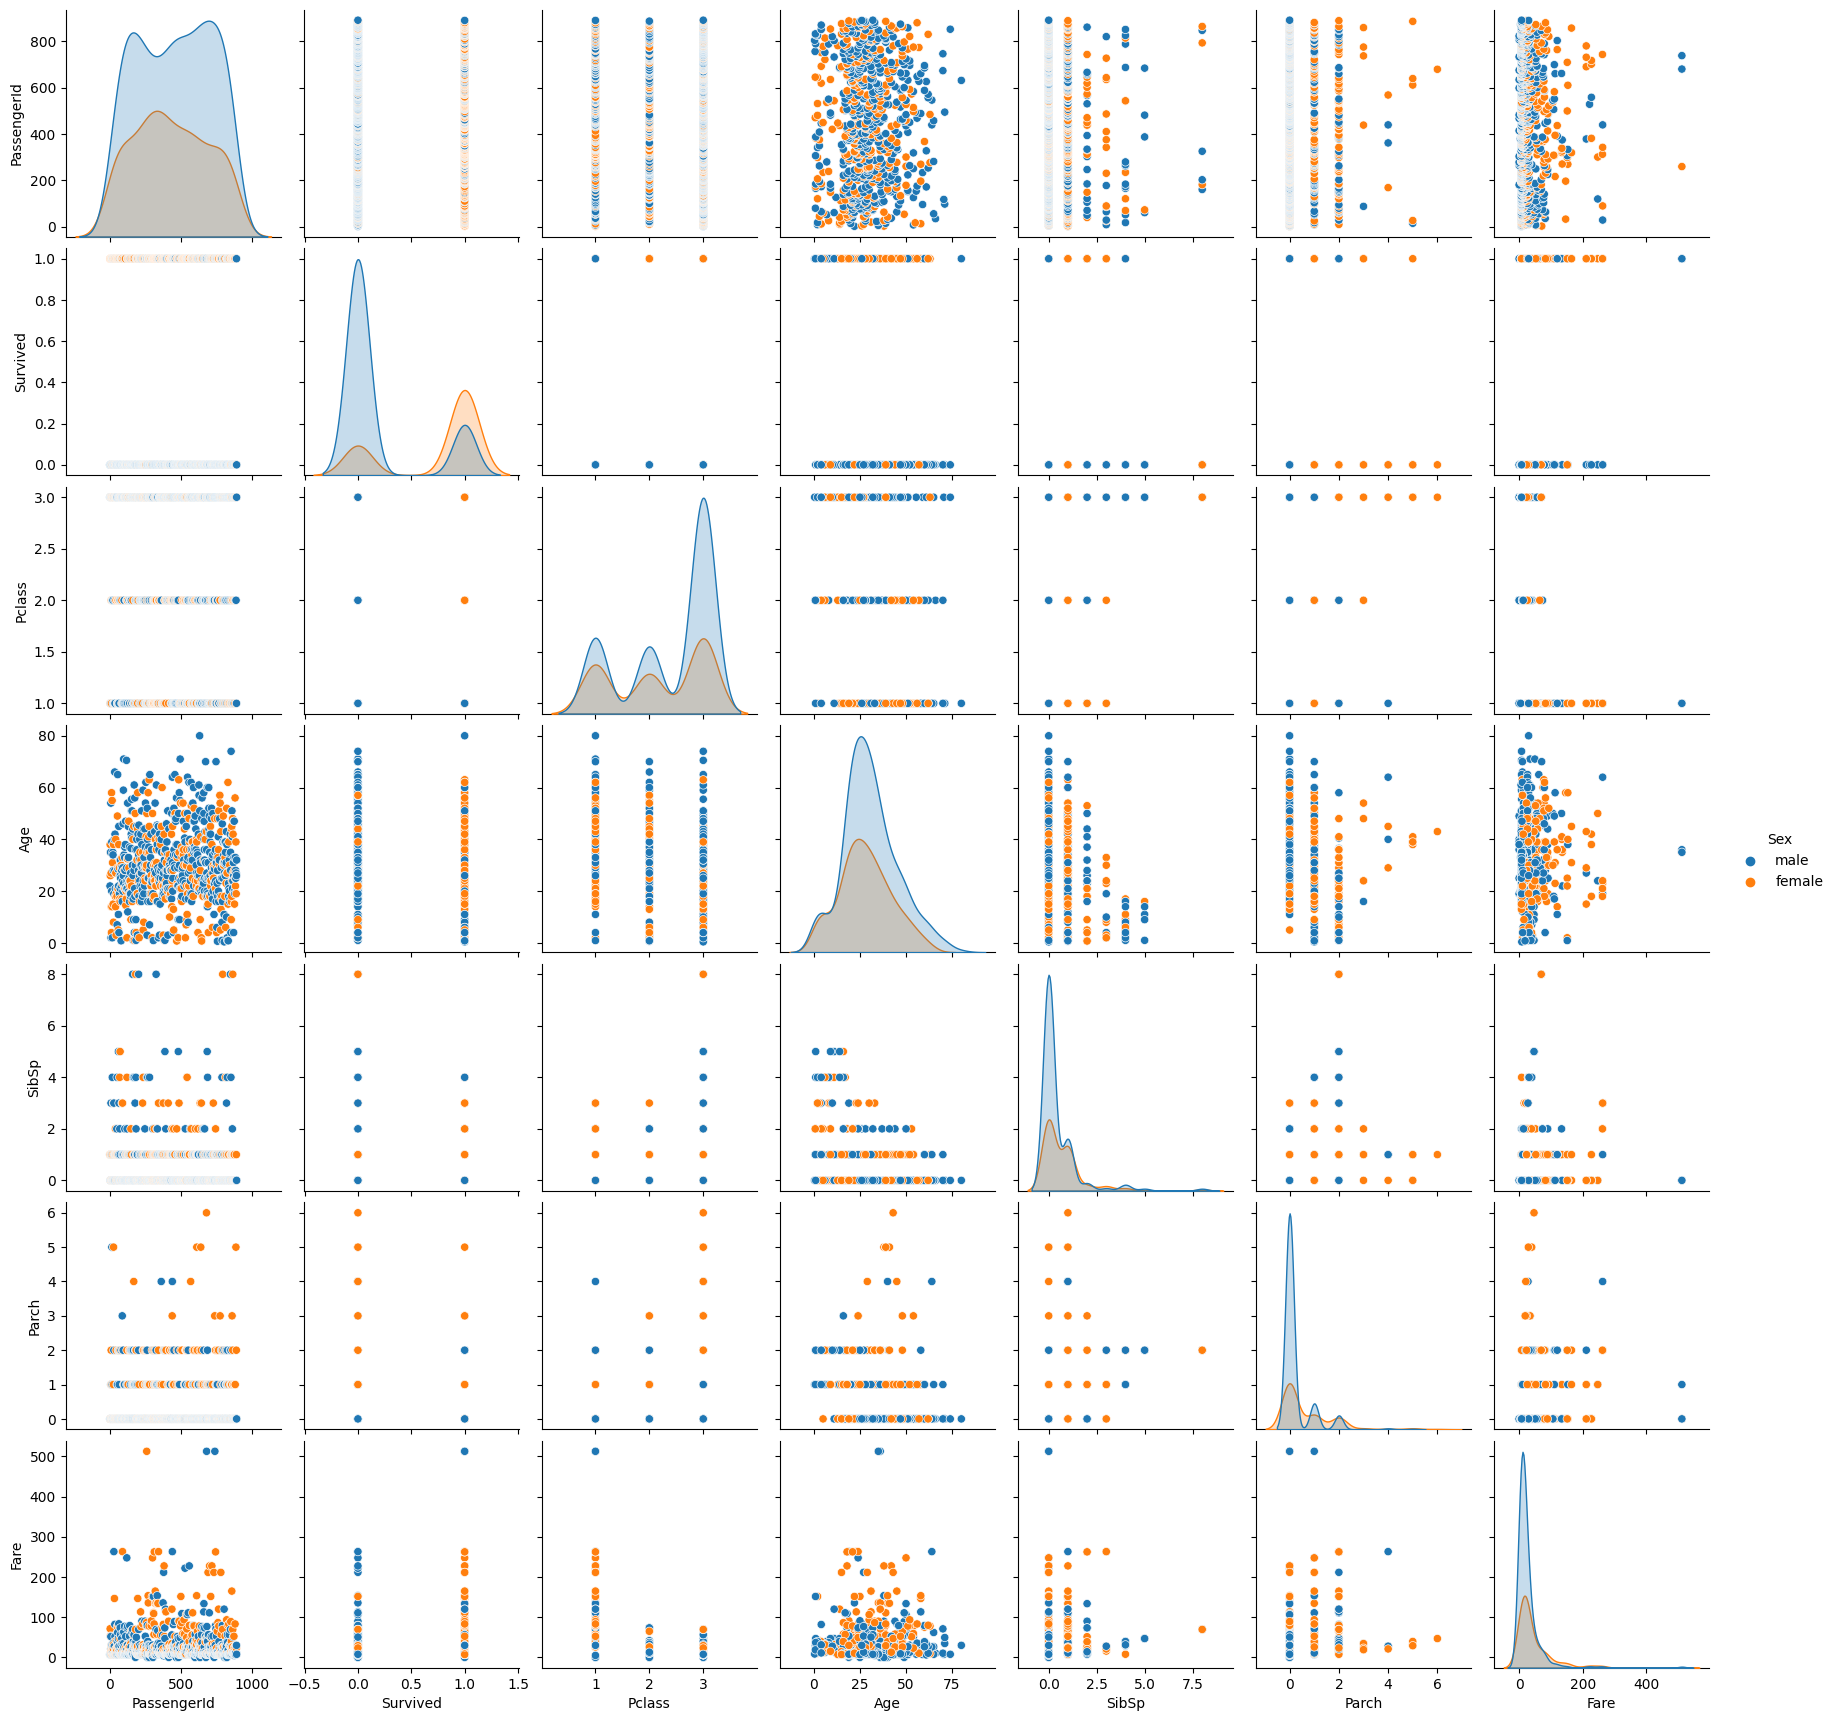

In [4]:
sns.pairplot(train,hue="Sex")

In [5]:
def prepare_data(df):
    df = df.copy()

    # Remplir les valeurs manquantes
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Cabin'] = df['Cabin'].fillna('Unknown')

    # Supprimer les colonnes inutiles
    df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

    # Encodage automatique : one-hot encoding
    df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

    return df


In [6]:
X = prepare_data(train.drop('Survived', axis=1))
y = train['Survived']
X_test = prepare_data(test)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
#Créer les DMatrix pour XGBoost
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)
#Paramètres + entraînement
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 4,
    'seed': 42
}

evals_result = {}

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False
)


In [8]:
from sklearn.metrics import accuracy_score, classification_report

y_val_pred = xgb_model.predict(dval)
y_val_pred = (y_val_pred > 0.5).astype(int)

print("✅ Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


✅ Accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



In [9]:
y_test_pred = xgb_model.predict(dtest)
y_test_pred = (y_test_pred > 0.5).astype(int)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_test_pred
})
submission.to_csv("submission_xgb_simple.csv", index=False)
print("✅ Fichier de soumission 'submission_xgb_simple.csv' créé")


✅ Fichier de soumission 'submission_xgb_simple.csv' créé


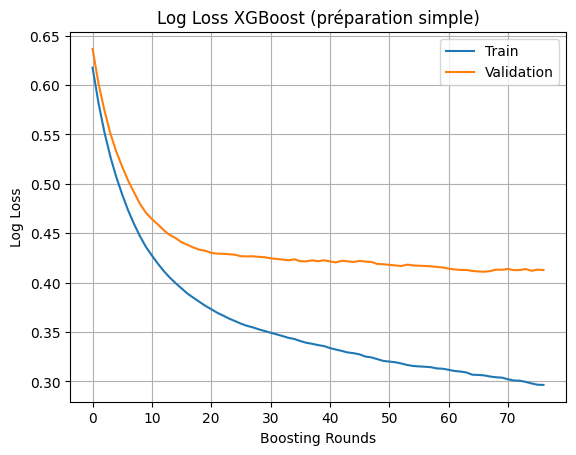

In [10]:
import matplotlib.pyplot as plt

plt.plot(evals_result['train']['logloss'], label='Train')
plt.plot(evals_result['val']['logloss'], label='Validation')
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Log Loss XGBoost (préparation simple)")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
xgb_model.save_model("xgb_model.model")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:18:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
